In [1]:
using Distributions

First we'll make some data, and try to see how well the regression recovers the parameters.

In [2]:
# Generate some data

a = 0.45
b = 4.2

n_samples = 20

xs = zeros(n_samples)
ys = zeros(n_samples)

for i in 1:n_samples
    x = rand(Normal())
    xs[i] = x
    ys[i] = a * x + b + rand(Normal(0, 0.5))
end

In [3]:
using Plots

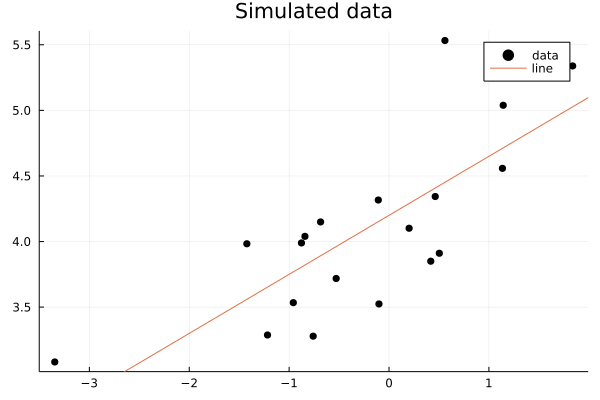

In [4]:
p = scatter(xs, ys, label="data", color="black", title="Simulated data")

Plots.abline!(p, a, b, label="line")

In [5]:
savefig(p, "figures/linear_data.pdf")

# Frequentist model

We'll try to fit a small model, in frequentist and bayesian case.

In [6]:
using GLM

In [7]:
using DataFrames

In [8]:
dataframe = DataFrame(:x => xs, :y => ys) |> df -> sort(df, :x)

,x,y
,Float64,Float64
1,-3.34628,3.08185
2,-1.4232,3.98294
3,-1.21643,3.28743
4,-0.958205,3.53406
5,-0.876541,3.9893
6,-0.841542,4.03955
7,-0.759272,3.2785
8,-0.685242,4.1494
9,-0.52909,3.71835


In [9]:
lm_freq = lm(@formula(y ~ 1 + x), dataframe)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  4.23032    0.105364   40.15    <1e-18   4.00896    4.45169
x            0.474963   0.0905068   5.25    <1e-04   0.284815   0.665111
────────────────────────────────────────────────────────────────────────

To look how our model looks, we'll plot predictions.

In [10]:
μ_y = predict(lm_freq, dataframe)

20-element Vector{Union{Missing, Float64}}:
 2.640965702798224
 3.5543554449177703
 3.652563626728566
 3.775212651737556
 3.8140000636851785
 3.830623266820375
 3.8696984380507304
 3.9048599522919285
 3.9790264405330733
 4.17932160839822
 4.182470435761751
 4.325860927559956
 4.42890096958975
 4.450095276601685
 4.469521093331195
 4.496155324189884
 4.769714104979376
 4.773358641255342
 4.847221560501999
 5.103525525514028

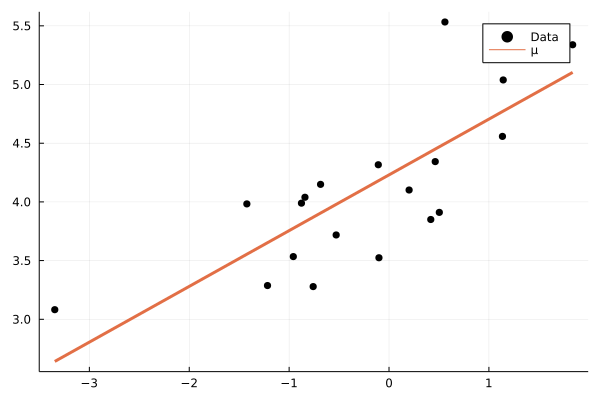

In [11]:
p = scatter(dataframe[!,:x], dataframe[!,:y], label="Data", color="black")
plot!(p, dataframe[!,:x], μ_y, label="μ", w=3)

In [12]:
conf_int = predict(lm_freq, dataframe, interval=:confidence);

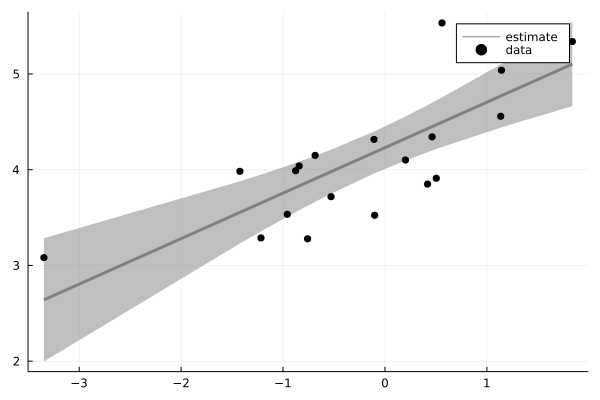

In [13]:
plot(dataframe[!,:x], μ_y, ribbon=(conf_int[!,:upper] .- μ_y,
                                   μ_y .- conf_int[!,:lower]),
     color="grey", label="estimate", w=3)
scatter!(dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], conf_int[!,:upper], color="grey", label=missing)
# plot!(dataframe[!,:x], conf_int[!,:lower], color="grey", label=missing)

In [14]:
pred_int = predict(lm_freq, dataframe, interval=:prediction);

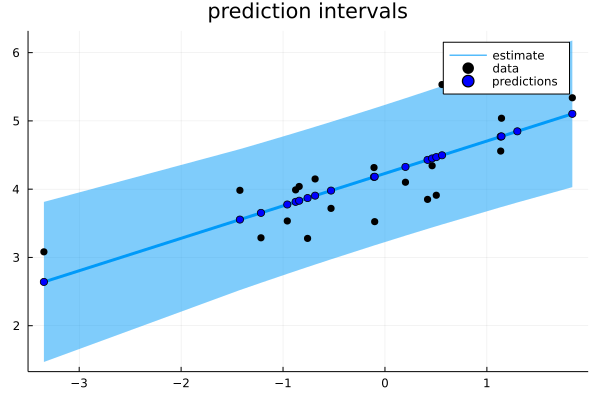

In [15]:
p = plot(dataframe[!,:x], μ_y, ribbon=(pred_int[!,:upper] .- μ_y,
                                       μ_y .- pred_int[!,:lower]),
      label="estimate", title="prediction intervals", w=3)

scatter!(p, dataframe[!,:x], dataframe[!,:y], label="data", color="black")
scatter!(dataframe[!,:x], pred_int[!,:prediction], color="blue", label="predictions")
# plot!(dataframe[!,:x], pred_int[!,:lower], color="green", label=missing)
# plot!(dataframe[!,:x], pred_int[!,:upper], color="green", label=missing)

In [16]:
savefig(p, "figures/linear_prediction_interval.pdf")

We can see that the *prediction intervals* include the error around the line. But do they include the error *in* the lines (that we see the confidence intervals have different widths!)

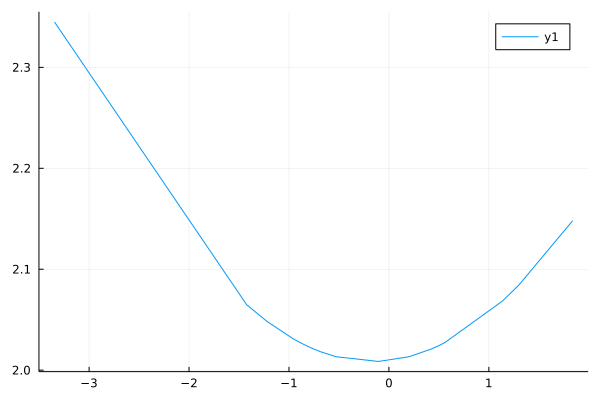

In [17]:
plot(dataframe[!,:x], pred_int[!,:upper] .- pred_int[!,:lower])

The answer is yes. They also include the uncertainty as to where the line is!

# Bayesian model

In [18]:
using Turing

In [19]:
@model function linear(xs, ys)
    l = length(xs)
    
    # Priors for lines
    a ~ Normal(0, 1)
    b ~ Normal(0, 3)
    
    # Prior for variance of points with line
    sigma ~ Exponential(0.2)
    
    for i in 1:l
        expected = a * xs[i] + b
        ys[i] ~ Normal(expected, sigma)
    end
    
    return ys
end

linear (generic function with 2 methods)

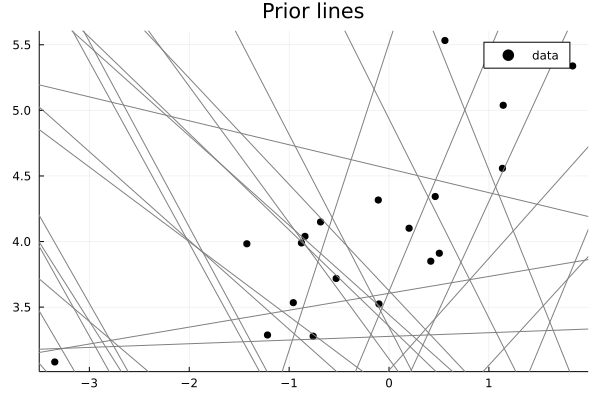

In [20]:
# Sampling from prior

N = 100
as = rand(Normal(0, 1), N)
bs = rand(Normal(0, 3), N)

p = scatter(dataframe[!,:x], dataframe[!,:y], label="data", title="Prior lines",
    color="black")
for i in 1:N
    Plots.abline!(p, as[i], bs[i], label=missing, color="gray")
end

p

In [21]:
savefig(p, "figures/linear_prior_lines.pdf")

In [22]:
model = linear(xs, ys)
chain = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 14.38 seconds
Compute duration  = 14.38 seconds
parameters        = a, b, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           a    0.4726    0.0898     0.0020    0.0022   1649.6201    0.9995    ⋯
           b    4.2270    0.1079     0.0024    0.0021   1832.2833    0.9997    ⋯
       sigma    0.4690    0.0753     0.0017    0.0020   1739.6965    1.0006    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75

In [23]:
using StatsPlots

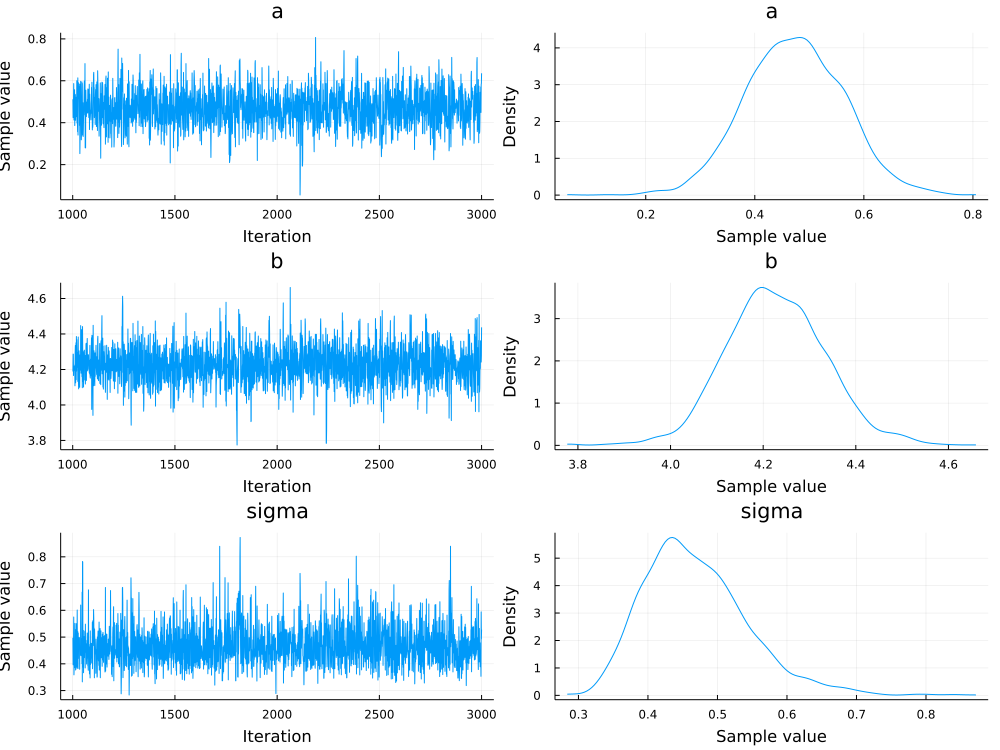

In [24]:
plot(chain)

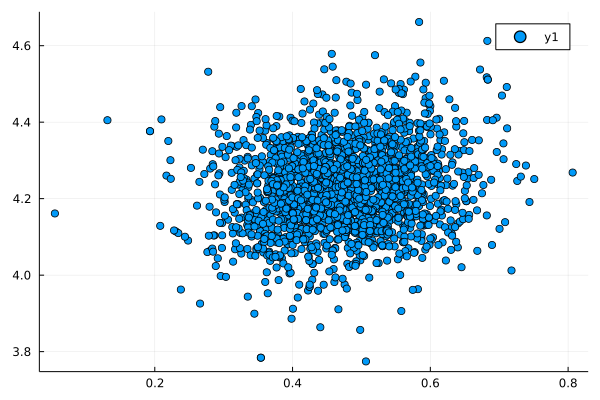

In [25]:
scatter(chain[:a], chain[:b])

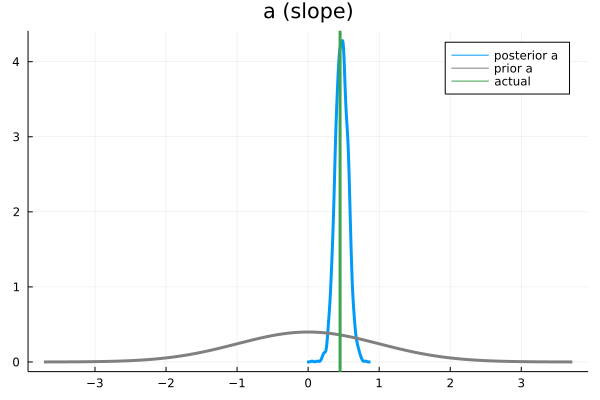

In [26]:
p_a = density(chain[:a], label="posterior a", title="a (slope)", w=3)

plot!(p_a, Normal(0, 1), label="prior a", color="gray", w=3)
vline!(p_a, [0.45], label="actual", w=3)

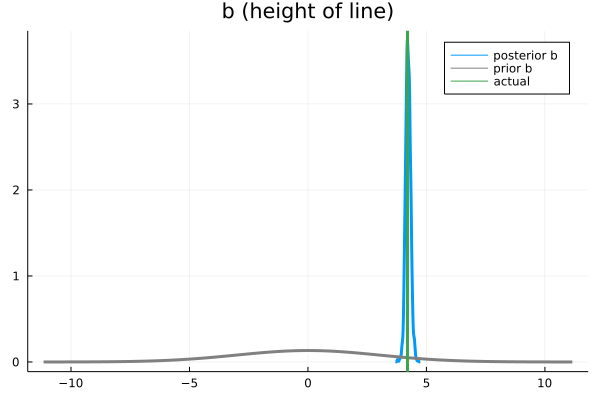

In [27]:
p_b = density(chain[:b], label="posterior b", title="b (height of line)", w=3)
plot!(p_b, Normal(0, 3), label="prior b", color="gray", w=3)
vline!(p_b, [4.2], label="actual", w=3)

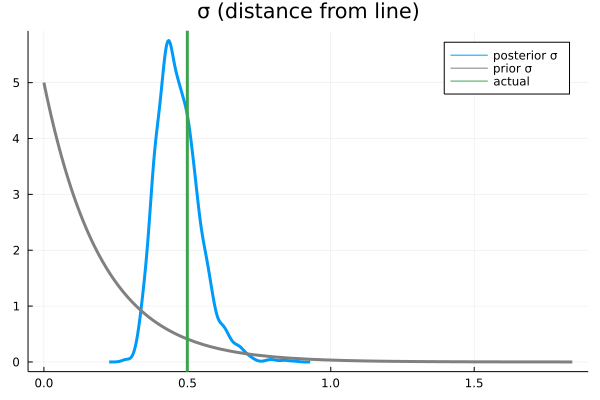

In [28]:
p_σ = density(chain[:sigma], label="posterior σ", title="σ (distance from line)", w=3)

plot!(p_σ, Exponential(0.2), label="prior σ", color="gray", w=3)

vline!(p_σ, [0.5], label="actual", w=3)

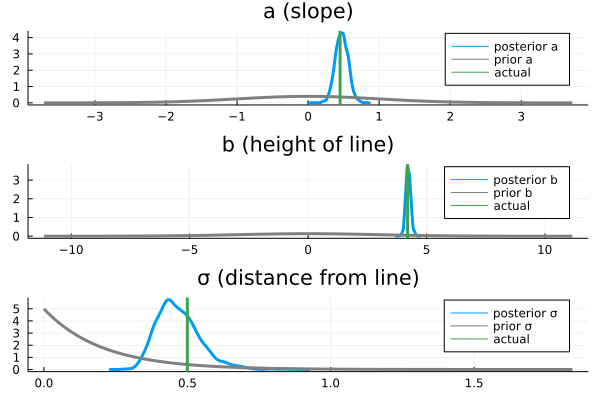

In [29]:
p_posteriors = plot(p_a, p_b, p_σ, layout=(3,1))

In [30]:
savefig(p_posteriors, "figures/posterior_parameters.pdf")

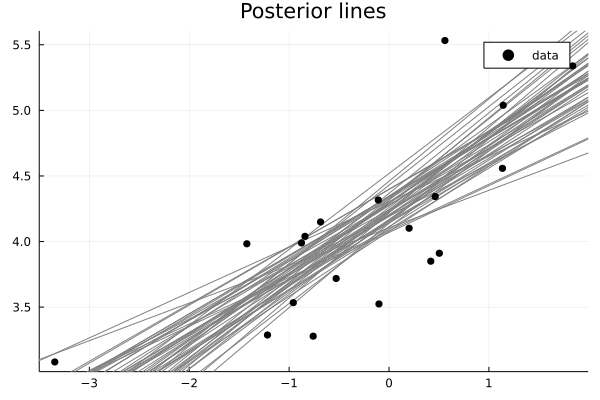

In [31]:
p = plot(title="Posterior lines")

for i in 1:50
    id = rand(1:2000)
    a = chain[:a][id]
    b = chain[:b][id]
    
    Plots.abline!(p, a, b,
        label=missing,
        color="gray")
end

scatter!(p, dataframe[!, :x], dataframe[!,:y], color="black", label="data")

p

In [32]:
savefig(p, "figures/posterior_lines.pdf")

We see we get a distribution of many lines, which show the uncertainty. 
Now, how do you make predictions with such a model? 

# Bayesian predictions

In [33]:
# Prediction
model = linear([0.0, 1.0], [missing, missing])

prediction = predict(model, chain)

Chains MCMC chain (2000×2×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
parameters        = ys[1], ys[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

       ys[1]    4.2362    0.4902     0.0110    0.0128   1903.8022    1.0007
       ys[2]    4.6918    0.4938     0.0110    0.0114   1822.9523    0.9995

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       ys[1]    3.2622    3.9084    4.2356    4.5476    5.2355
       ys[2]    3.7616    4.3520    4.6882    4.9974    5.7529


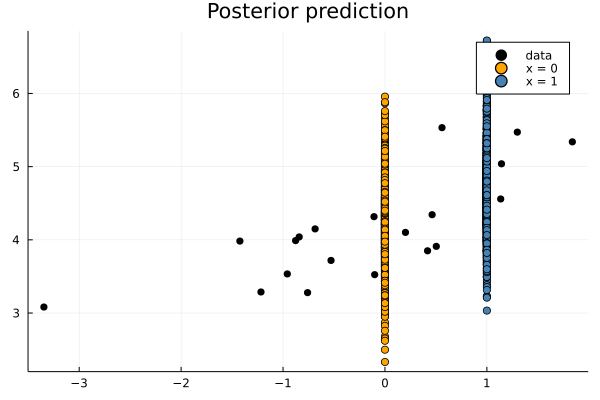

In [34]:
p = scatter(dataframe[!, :x], dataframe[!,:y], color="black", label="data",
    title="Posterior prediction")

scatter!(repeat([0.0], 2000), prediction["ys[1]"], label="x = 0", color="orange")
scatter!(repeat([1.0], 2000), prediction["ys[2]"], label="x = 1", color="steelblue")

In [35]:
savefig(p, "figures/predictions.pdf")

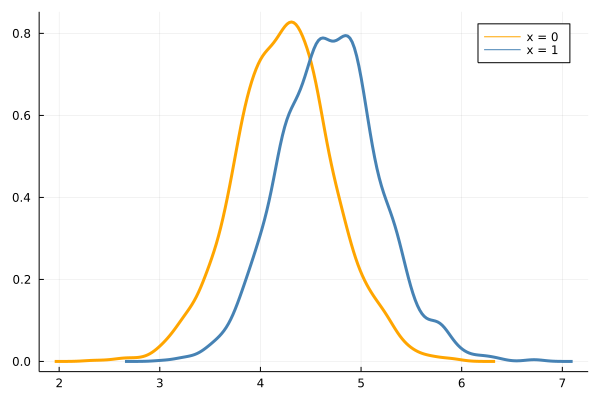

In [36]:
p_predictions = density(prediction["ys[1]"], label="x = 0", color="orange", w=3)
density!(p_predictions, prediction["ys[2]"], label="x = 1", color="steelblue", w=3)

In [37]:
savefig(p_predictions, "figures/prediction_distrubtions.pdf")

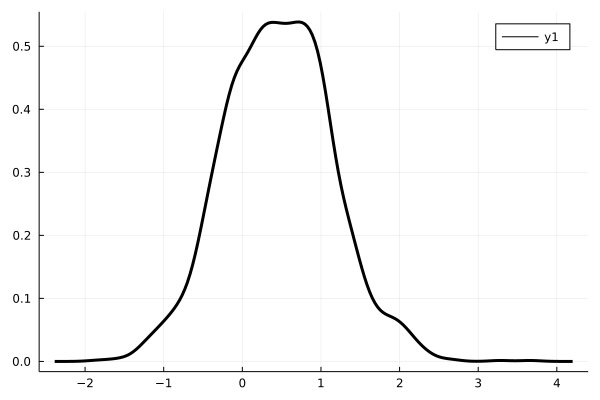

In [38]:
p = density(prediction["ys[2]"] .- prediction["ys[1]"], color="black", w=3)

In [39]:
savefig(p, "figures/prediction_difference.pdf")

# Interactions

This time, we'll consider we have two lines.

This is a reason to show a hierarchical model, that's how we add some hyperpriors. 

In [122]:
function generate_interaction()
    # Number of points
    N = 100
    
    a1 = 1.15
    a2 = 0.8
    
    b1 = 2.0
    b2 = 2.3
    
    # Samples don't have the same size.
    p = 0.6
    
    xs = rand(Normal(), N)
    ys = zeros(N)
    cs = zeros(N)
    
    stdev = 1.0 
    
    for i in 1:N
        coin = rand(Bernoulli(p))
        cs[i] = coin
        if coin == 1
            mean = a1 * xs[i] + b1
            ys[i] = rand(Normal(mean, stdev))
        else
            mean = a2 * xs[i] + b2
            ys[i] = rand(Normal(mean, stdev))
        end
    end
    return (xs, ys, cs)
end

generate_interaction (generic function with 1 method)

In [123]:
(xs, ys, cs) = generate_interaction()
interaction_samples = DataFrame(:x => xs, :flip => cs, :y => ys) |> df -> sort(df, :x)

,x,flip,y
,Float64,Float64,Float64
1,-2.13769,0.0,1.39005
2,-1.96598,1.0,-0.0908657
3,-1.87919,0.0,-0.893256
4,-1.78488,1.0,0.74621
5,-1.7463,1.0,1.20665
6,-1.71886,1.0,-0.508246
7,-1.6414,0.0,1.19064
8,-1.60907,1.0,2.60899
9,-1.58618,1.0,0.0724197


In [124]:
red = filter(r -> r[:flip] == 0.0, interaction_samples)
blue = filter(r -> r[:flip] == 1.0, interaction_samples)

,x,flip,y
,Float64,Float64,Float64
1,-1.96598,1.0,-0.0908657
2,-1.78488,1.0,0.74621
3,-1.7463,1.0,1.20665
4,-1.71886,1.0,-0.508246
5,-1.60907,1.0,2.60899
6,-1.58618,1.0,0.0724197
7,-1.47093,1.0,-0.619007
8,-1.3864,1.0,2.29571
9,-1.31728,1.0,-0.364047


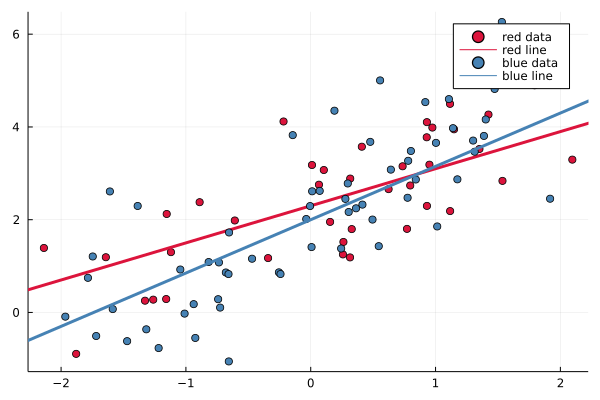

In [125]:
red_blue_plot = scatter(red[!,:x], red[!,:y], color="crimson", label="red data")
Plots.abline!(red_blue_plot, 0.8, 2.3, w=3, color="crimson", label="red line")

blue_plot = scatter!(red_blue_plot, 
    blue[!,:x], blue[!,:y], color="steelblue", label="blue data")
Plots.abline!(red_blue_plot, 1.15, 2.0, w=3, color="steelblue", label="blue line")

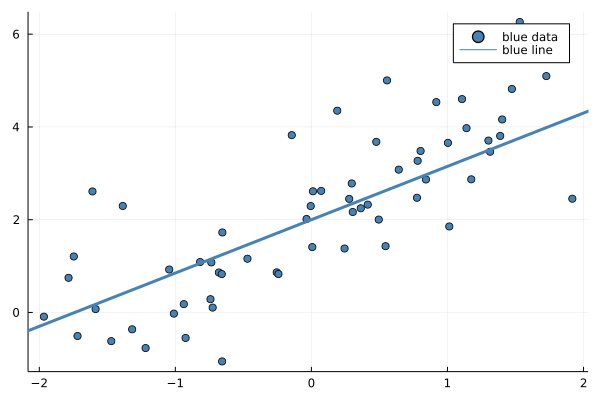

In [126]:
red_plot = scatter(red[!,:x], red[!,:y], color="crimson", label="red data")
Plots.abline!(red_plot, 0.8, 2.3, w=3, color="crimson", label="red line")

blue_plot = scatter(blue[!,:x], blue[!,:y], color="steelblue", label="blue data")
Plots.abline!(blue_plot, 1.15, 2.0, w=3, color="steelblue", label="blue line")

Usually, people will do linear regression on the two groups separately and try to compare. This plot is to show that. 

Instead, we'll suggest to create a *family of lines*, and use hyper-priors, so the red line learns from the data *and* from the blue line.

We should have a drawing showing that the red data influences the red line, which influences the hyper-prior, which influences the blue line.

**Important**: Hyper-priors are *adaptive priors* that are partially learned from the data.

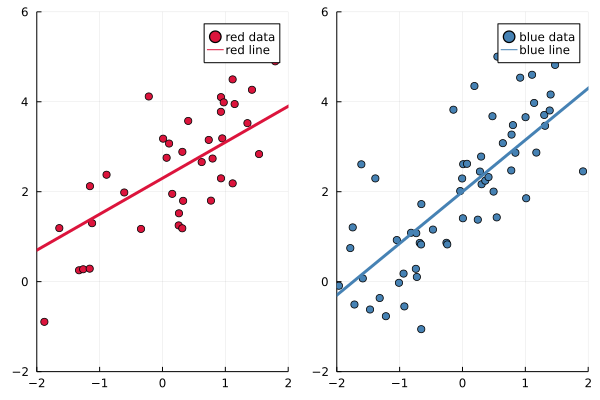

In [127]:
plot(red_plot, blue_plot, xrange=(-2, 2), yrange=(-2, 6))

In [128]:
@model function interaction_model(N, xs, ys, cs)
    sigma_slopes ~ Exponential(0.05)
    
    a1 ~ Normal(0.0, sigma_slopes)
    a2 ~ Normal(0.0, sigma_slopes)
    
    b1 ~ Normal(0.0, 1.5)
    b2 ~ Normal(0.0, 1.5)
    
    sigma ~ Exponential(1.0)
    
    for i in 1:N
        if cs[i] == 1.0
            mu_1 = a1 * xs[i] + b1
            ys[i] ~ Normal(mu_1, sigma)
        else
            mu_2 = a2 * xs[i] + b2
            ys[i] ~ Normal(mu_2, sigma)
        end
    end
end

interaction_model (generic function with 2 methods)

In [129]:
m_interaction = interaction_model(100, interaction_samples[!,:x],
    interaction_samples[!,:y],
    interaction_samples[!,:flip])

chain_interaction = sample(m_interaction, NUTS(0.65), 5000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×18×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 2.8 seconds
Compute duration  = 2.8 seconds
parameters        = sigma_slopes, a1, a2, b1, b2, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

  sigma_slopes    0.4792    0.0956     0.0014    0.0015   4643.4046    0.9999  ⋯
            a1    1.2174    0.1281     0.0018    0.0016   5033.3762    0.9998  ⋯
            a2    0.8424    0.1496     0.0021    0.0021   5042.5072    0.9999  ⋯
            b1    2.0824    0.1260     0.0018    0.0015   6352.1904    1.0000  ⋯
            b2    2.2698    0.1608     0

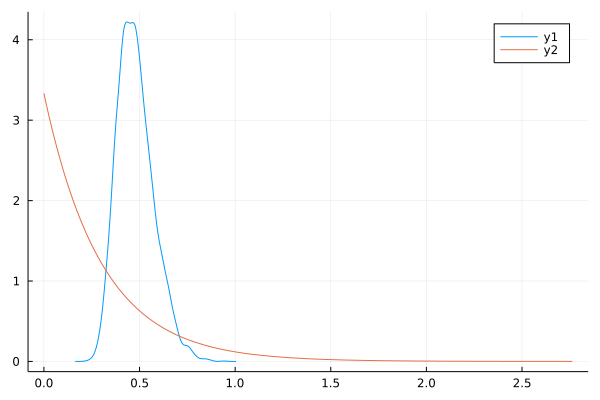

In [130]:
p = density(chain_interaction[:sigma_slopes])
plot!(p, Exponential(0.3))

The plot above shows that the slopes of the lines were a little more different than I expected.

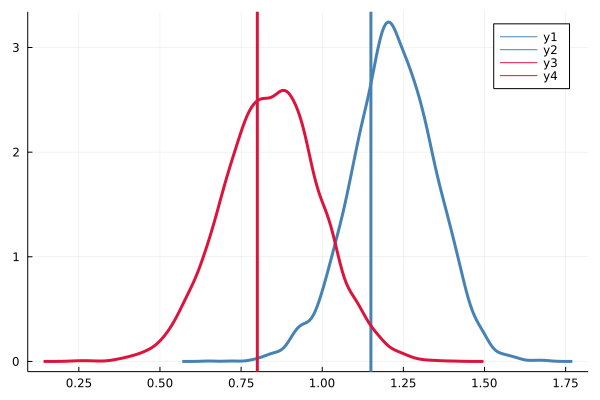

In [131]:
p = density(chain_interaction[:a1], color="steelblue", w=3)
vline!(p, [1.15], color="steelblue", w=3)

density!(p, chain_interaction[:a2], color="crimson", w=3)
vline!(p, [0.8], color="crimson", w=3)

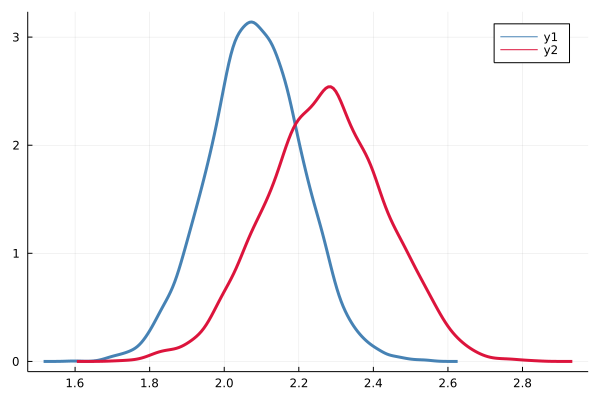

In [132]:
p = density(chain_interaction[:b1], color="steelblue", w=3)
density!(p, chain_interaction[:b2], color="crimson", w=3)